<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Projects/flower_recognition_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Recognition (Kaggle)

[Link to the Kaggle page](https://www.kaggle.com/alxmamaev/flowers-recognition)

This dataset contains 4242 images of flowers.

The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

## Content
The pictures are divided into five classes: 
* chamomile 
* tulip
* rose
* sunflower 
* dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## My words 

This is the first Project I built using TensorFlow, it was hella fun and gave me a overview of how to get things done with TensorFlow, whilst taking the course [TensorFlow Developer Certificate in 2021 - ZTM](https://academy.zerotomastery.io/p/learn-tensorflow)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Importing the needed packages for now 
import tensorflow as tf 
import pathlib 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os


In [ ]:
# Getting the class names 

# Turn into a path object
data_dir = pathlib.Path('../input/flowers-recognition/flowers/flowers') 

# Create a list of class names from sub directories 
# class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
class_names = os.listdir('../input/flowers-recognition/flowers/flowers')
class_names

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [ ]:
# Visualizing some images 
import matplotlib.image as mpimg
import random 

def view_random_image(target_dir , target_class):
    '''
    Select an image randomly from the path regardless the class and plot the image for us
    '''
    
    # Setup the target directory (we'll view images from here)
    target_folder = target_dir+target_class
    
    # Get a random image path 
    random_image = random.sample(os.listdir(target_folder) , 1) # randomly get one of the iterms from here
    print(f'The random_image variable returns: {random_image}')
    
    # Read in the image and plot it using matplotlib 
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class) # Displaying the class name depending on the image getting plotted 
    plt.axis(False)
    
    print(f'Image shape: {img.shape}')
    
    return img 

The random_image variable returns: ['1667199972_7ba7d999c1_m.jpg']
Image shape: (240, 180, 3)


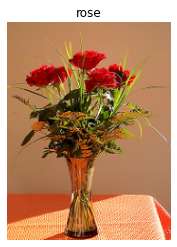

In [ ]:
rose_img = view_random_image(target_dir = '../input/flowers-recognition/flowers/' , 
                       target_class = 'rose')

The random_image variable returns: ['7166644048_b00a14f01b.jpg']
Image shape: (333, 500, 3)


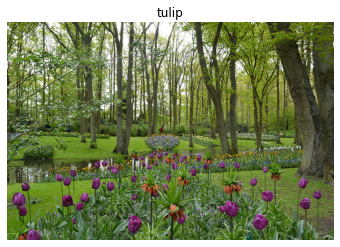

In [ ]:
tulip_img = view_random_image(target_dir = '../input/flowers-recognition/flowers/' , 
                             target_class ='tulip')

We have loaded in our images, let's pre-process it before putting it in our model

In [ ]:
# Setting up default batch and image size 
BATCH_SIZE = 32 
IMG_SIZE = (224 , 224)

In [ ]:
# Let's create a function which could help us split and apply data augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def image_data_generator(data_dir , 
                        data_augment = False , 
                        batch_size = BATCH_SIZE , 
                        target_size = IMG_SIZE , 
                        class_mode = 'categorical' , 
                        shuffle = True ):
    '''
    This function helps us to apply the data augmentation only on train set, only by setting the 
    data_augment to `True` will apply the transforms
    '''
    
    
    
    if data_augment:
        datagen = ImageDataGenerator(rescale = 1/255. , 
                                    rotation_range = 20 , 
                                    shear_range = 0.2 , 
                                    zoom_range = 0.2 , 
                                    horizontal_flip = True , 
                                    width_shift_range = 0.2 , 
                                    height_shift_range = 0.2 , 
                                    validation_split = 0.2)
    else:
        datagen = ImageDataGenerator(rescale = 1/255.)
        
    generator = datagen.flow_from_directory(data_dir , 
                                           target_size = target_size , 
                                           class_mode = class_mode , 
                                           batch_size = batch_size  , 
                                           shuffle = shuffle )
    
    return generator


## Let's Build a Baseline model 

In [ ]:
# Let's build a datagenerator with no augmentation for our baseline model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an instance of a generator 
train_datagen = ImageDataGenerator(rescale = 1/255. , 
                                  validation_split = 0.2)

# Import data from the directoriess and turn into batches + create labels 
# Train data
train_data_not_augmented = train_datagen.flow_from_directory(data_dir , 
                                                            target_size = IMG_SIZE , 
                                                            batch_size = BATCH_SIZE , 
                                                            shuffle = True , 
                                                            class_mode = 'categorical' ,
                                                            seed = 42)
# Validation data 
valid_data_not_augmented = train_datagen.flow_from_directory(data_dir , 
                                                            target_size = IMG_SIZE , 
                                                            batch_size = BATCH_SIZE , 
                                                            class_mode = 'categorical' , 
                                                            subset = 'validation' , 
                                                            seed = 42)


Found 4323 images belonging to 5 classes.
Found 861 images belonging to 5 classes.


In [ ]:
# Let's build a tiny vgg baseline model 
# Importing the needed packages 
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPool2D 
from tensorflow.keras import Sequential

base_model = Sequential([
    Conv2D(filters = 10 , 
          kernel_size = 3, 
          activation = tf.keras.activations.relu , 
          input_shape = (224 , 224 , 3)), 
    Conv2D(10 , 3 , activation= 'relu') , 
    MaxPool2D(pool_size = 2 , 
             padding = 'valid') , 
    Conv2D(10 , 3 , activation = 'relu'),
    Conv2D(10 , 3 , activation = 'relu'), 
    MaxPool2D(2) , 
    Flatten() , 
    Dense(5 , activation = tf.keras.activations.softmax)
])

# Checking the summary of our model 
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28090)             0

In [ ]:
# Compile the model 
base_model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                  optimizer = tf.keras.optimizers.Adam(), 
                  metrics = ['accuracy'])

# Fit the model 
base_history = base_model.fit(train_data_not_augmented , 
              epochs = 5, 
              steps_per_epoch = len(train_data_not_augmented) , 
              validation_data = valid_data_not_augmented , 
              validation_steps = len(valid_data_not_augmented))

Epoch 1/5
136/136 [==============================] - 18s 129ms/step - loss: 1.1654 - accuracy: 0.5357 - val_loss: 0.9638 - val_accuracy: 0.6434
Epoch 2/5
136/136 [==============================] - 18s 130ms/step - loss: 0.9611 - accuracy: 0.6310 - val_loss: 0.7388 - val_accuracy: 0.7410
Epoch 3/5
136/136 [==============================] - 17s 127ms/step - loss: 0.7484 - accuracy: 0.7338 - val_loss: 0.5336 - val_accuracy: 0.8409
Epoch 4/5
136/136 [==============================] - 18s 133ms/step - loss: 0.5573 - accuracy: 0.8105 - val_loss: 0.3219 - val_accuracy: 0.9082
Epoch 5/5
136/136 [==============================] - 17s 128ms/step - loss: 0.3532 - accuracy: 0.8798 - val_loss: 0.2142 - val_accuracy: 0.9570


In [ ]:
# Plot the train and validation loss curve separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

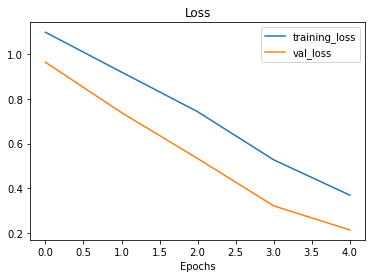

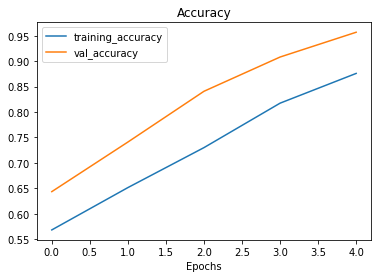

In [ ]:
# Using our function to plot the loss curves 
plot_loss_curves(base_history)

In [ ]:
# Evaluating our model 
base_model.evaluate(valid_data_not_augmented)

27/27 [==============================] - 3s 105ms/step - loss: 0.2142 - accuracy: 0.9570


[0.2142188996076584, 0.9570267200469971]

## Let's try and improve by adding data augmentation

In [ ]:
# Applying data augmentation to our train data
train_data_augmented = image_data_generator(data_dir , data_augment = True)

# We're not applying data augmentation to our valid data here 
valid_data_not_augmented = train_datagen.flow_from_directory(data_dir , 
                                                            target_size = IMG_SIZE , 
                                                            batch_size = BATCH_SIZE , 
                                                            class_mode = 'categorical' , 
                                                            subset = 'validation' , 
                                                            seed = 42)

Found 4323 images belonging to 5 classes.
Found 861 images belonging to 5 classes.


In [ ]:
# Fitting our model with augmented training data 
history_aug = base_model.fit(train_data_augmented , 
                            epochs = 5 , 
                            steps_per_epoch = len(train_data_augmented) , 
                            validation_data = valid_data_not_augmented , 
                            validation_steps = len(valid_data_not_augmented))

Epoch 1/5
136/136 [==============================] - 55s 407ms/step - loss: 1.1000 - accuracy: 0.5667 - val_loss: 0.5582 - val_accuracy: 0.8328
Epoch 2/5
136/136 [==============================] - 56s 413ms/step - loss: 1.0179 - accuracy: 0.6028 - val_loss: 0.6152 - val_accuracy: 0.7944
Epoch 3/5
136/136 [==============================] - 56s 410ms/step - loss: 0.9869 - accuracy: 0.6142 - val_loss: 0.5794 - val_accuracy: 0.8095
Epoch 4/5
136/136 [==============================] - 56s 409ms/step - loss: 0.9638 - accuracy: 0.6287 - val_loss: 0.6542 - val_accuracy: 0.7921
Epoch 5/5
136/136 [==============================] - 56s 414ms/step - loss: 0.9599 - accuracy: 0.6283 - val_loss: 0.6740 - val_accuracy: 0.7793


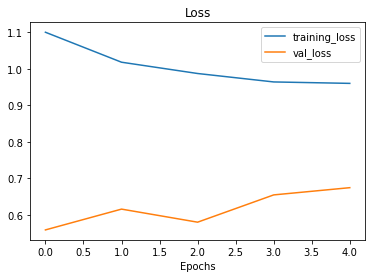

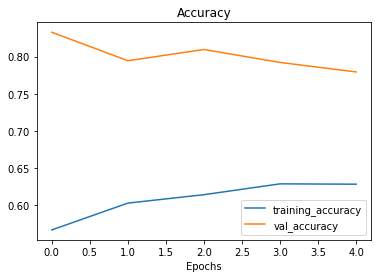

In [ ]:
# Plotting the loss curves 
plot_loss_curves(history_aug)

Seems augmented data isn't performing well. Whereas the non-augmented data worked like a gem. We can further improve it, but this is my first project on TensorFlow whilst taking the course [TensorFlow Developer Certificate in 2021 - ZTM](https://academy.zerotomastery.io/p/learn-tensorflow)